# scratch work

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import warnings

import astropy.units as u
import emcee
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from emcee.autocorr import AutocorrError

from jorbit import Observations, Particle


In [2]:
nights = [Time("2025-01-01 07:00"), Time("2025-01-02 07:00"), Time("2025-01-05 07:00")]

times = []
for n in nights:
    times.extend([n + i * 1 * u.hour for i in range(3)])
times = Time(times)


# obj = Horizons(id="274301", location="695@399", epochs=times.utc.jd)
obj = Horizons(id="90377", location="695@399", epochs=times.utc.jd)
pts = obj.ephemerides(extra_precision=True, quantities="1")

coords = SkyCoord(pts["RA"], pts["DEC"], unit=(u.deg, u.deg))
times = Time(pts["datetime_jd"], format="jd", scale="utc")


obs = Observations(
    observed_coordinates=coords,
    times=times,
    observatories="kitt peak",
    astrometric_uncertainties=1 * u.arcsec,
)


# obj = Horizons(id="274301", location="500@0", epochs=times.tdb.jd[0])
obj = Horizons(id="90377", location="500@0", epochs=times.tdb.jd[0])
vecs = obj.vectors(refplane="earth")
true_x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
true_v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]


# p0 = Particle(
#     x=true_x0, v=true_v0, time=times[0], name="274301 Wikipedia", observations=obs
# )
p0 = Particle(
    x=true_x0, v=true_v0, time=times[0], name="90377 Sedna", observations=obs,
)
p0

Particle: 90377 Sedna

In [4]:
samples = p0.fit_mcmc(
    p0.cartesian_state,
    n_walkers=18,
    n_steps=2500,
    thin="auto",
    n_burn_steps="auto",
    flat=False,
    verbose=True,
)

100%|██████████| 2500/2500 [23:10<00:00,  1.80it/s]
/var/folders/mj/qxz5chg95r53_2nlv9f86qhm0000gn/T/ipykernel_41487/1063795637.py:1: UserWarning: emcee could not compute the autocorrelation time, chain is likely too short. Proceeding without any thinning.
  samples = p0.fit_mcmc(


In [5]:
samples.shape

(28251, 6)

In [5]:
samples

Array([[1.0036754 , 0.99091796, 0.9799356 , 1.00160563, 1.00132334,
        0.98694565],
       [0.99594432, 0.98206465, 0.98643345, 1.00809585, 0.9962022 ,
        1.00084428]], dtype=float64)

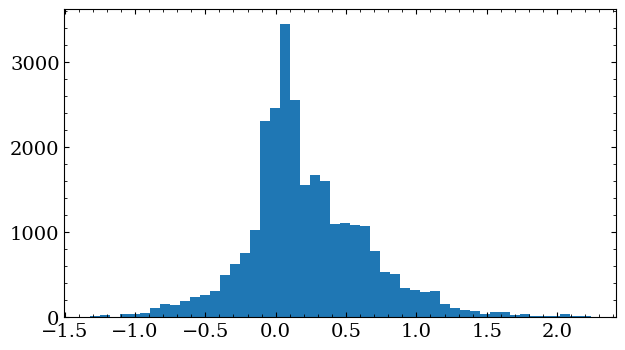

In [11]:
plt.hist(samples[:, 5], bins=50);

In [8]:
%timeit p0.scipy_objective(jnp.concatenate([true_x0, true_v0])).block_until_ready()

31.2 ms ± 459 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
31.2 * 32

998.4

In [16]:
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)


nwalkers = 32
p0 = np.random.rand(nwalkers, ndim) - 10


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

state = sampler.run_mcmc(p0, 1_000, progress=True)

100%|██████████| 1000/1000 [00:00<00:00, 2310.73it/s]


In [17]:
def process_emcee_chains(sampler, thin="auto", n_burn_steps="auto"):
    x = sampler.get_chain()

    if n_burn_steps == "auto":
        # find the point where each chain first crosses its median value
        medians = np.median(x, axis=0)
        above_median = x > medians[None, ...]
        crossings = above_median[:-1] != above_median[1:]
        first_med_crossings = np.argmax(crossings, axis=0)

        # nan out the everything before the first crossings:
        mask = np.arange(x.shape[0])[:, None, None] > first_med_crossings[None, ...]
        x = np.where(mask, x, np.nan)
    else:
        x = x[n_burn_steps:]

    if thin == "auto":
        try:
            tau = sampler.get_autocorr_time()
            thin = int(np.ceil(2 * tau.max()))
        except AutocorrError:
            warnings.warn(
                "emcee could not compute the autocorrelation time, chain is likely too short. Proceeding without any thinning.",
                stacklevel=2,
            )
            thin = 1

    # thin the chain
    x = x[::thin]

    # flatten the chain
    x = x.reshape(-1, ndim)

    # get rid of the nans
    x = x[~np.isnan(x).any(axis=1)]

    return x


q = process_emcee_chains(sampler, thin="auto", n_burn_steps="auto")

/var/folders/mj/qxz5chg95r53_2nlv9f86qhm0000gn/T/ipykernel_19347/2619845432.py:40: UserWarning: emcee could not compute the autocorrelation time, chain is likely too short. Proceeding without any thinning.
  q = process_emcee_chains(sampler, thin="auto", n_burn_steps="auto")


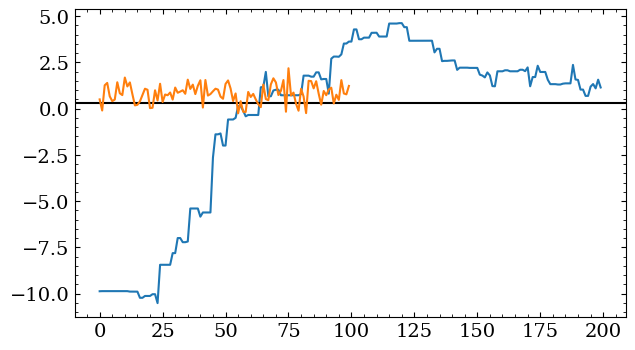

In [11]:
x = sampler.get_chain()
plt.plot(x[:200, 2, 0])
plt.axhline(np.median(x[:, 2, 0]), color="k")
plt.plot(q[:100, 2])

In [59]:
p = sampler.get_chain(thin=10)
x = sampler.get_chain()

In [55]:
x.shape, p.shape

((10000, 32, 5), (1000, 32, 5))

In [70]:
np.abs((p[0] - x).sum(axis=(1,2))).min()

np.float64(0.0)

In [71]:
np.where((p[0] - x).sum(axis=(1,2)) == 0)

(array([9]),)

In [72]:
x[9:][::10] - p

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0.,

In [6]:
try:
    obj = Horizons(id="K21RL9R", location="500@0", epochs=times.tdb.jd[0], id_type="smallbody")
    obj.vectors(refplane="earth")
except ValueError as e:
    if "Unknown target" in str(e):
        print("Unknown target")